In [1]:
import tensorflow as tf

import os
import time
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

In [2]:
# import tarfile
# my_tar = tarfile.open('/content/drive/MyDrive/NEW_JSOC_CODE_DATA/2012_13_14_train_test_1024images.tar.gz')
# my_tar.extractall('/content/drive/MyDrive/NEW_JSOC_CODE_DATA') # specify which folder to extract to
# my_tar.close()

In [3]:
# print(len(os.listdir('/content/drive/MyDrive/NEW_JSOC_CODE_DATA/2012_13_14_train_test/train')))
# print(len(os.listdir('/content/drive/MyDrive/NEW_JSOC_CODE_DATA/2012_13_14_train_test/test')))

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 1024
IMG_HEIGHT = 1024

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [113]:
PATH = '/content/drive/MyDrive/NEW_JSOC_CODE_DATA/2012_13_14_train_test/'

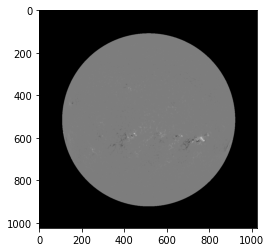

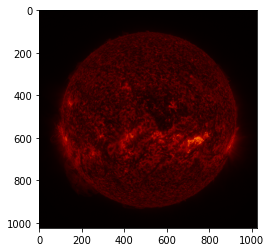

In [114]:
inp, re = load(PATH+'train/1600.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [115]:
c1 = inp[:,:,0].numpy()
c2 = inp[:,:,1].numpy()
c3 = inp[:,:,2].numpy()

In [116]:
# print(np.unique(c1))
# print(np.unique(c2))
# print(np.unique(c3))

In [117]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [118]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  # input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [119]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  # input_image, real_image = resize(input_image, real_image,
  #                                  IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [120]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [121]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [122]:
len(train_dataset)

1892

In [123]:
len(test_dataset)

200

In [124]:
OUTPUT_CHANNELS = 3

In [125]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [126]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 512, 512, 3)


In [127]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [128]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 1024, 1024, 3)


In [129]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[1024,1024,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    # modification
    downsample(512, 4), # (bs, 1, 1, 512)
    downsample(512, 4, apply_batchnorm=False) #  i have not used RelU/ in the paper RelU is used
    # modification
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    # modification
    upsample(512, 4),
    upsample(512, 4),

    # modification

    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [130]:
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=200)

In [131]:
# from keras.utils import plot_model
# plot_model(generator, to_file='/content/drive/MyDrive/NEW_JSOC_CODE_DATA/generator.png', 
#            show_shapes=True,
#            show_layer_names=True,
#            )

In [132]:
gen_output = generator(inp[tf.newaxis,...], training=False)
# plt.imshow(gen_output[0,...])

In [133]:
LAMBDA = 100

In [134]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [135]:

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[1024, 1024, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[1024, 1024, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
  # modification
  # modification

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [136]:
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [137]:
# from keras.utils import plot_model
# plot_model(discriminator, to_file='/content/drive/MyDrive/NEW_JSOC_CODE_DATA/discriminator.png', 
#            show_shapes=True,
#            show_layer_names=True,
#            )

In [138]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
# plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

In [139]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [140]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [141]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [142]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [144]:
def generate_train_images(model, test_input, tar, epoch):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input HMI Image', 'AIA0304 Ground Truth', 'AIA0304 Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i], fontdict={'fontsize':19})
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  filename1 = f'/content/drive/MyDrive/NEW_JSOC_CODE_DATA/ImagesAndModels/2012_13_14_second/image_{epoch}.png'
  plt.savefig(filename1, dpi=300, bbox_inches = 'tight',pad_inches = 0.2)
  plt.show()

  if (epoch % 15 == 0 or epoch == 149):
    filename2 = f'/content/drive/MyDrive/NEW_JSOC_CODE_DATA/ImagesAndModels/2012_13_14_second/model_{epoch}.h5'
    model.save(filename2)

In [145]:
# def generate_test_images(model, test_input, tar):
#   prediction = model(test_input, training=True)
#   plt.figure(figsize=(15,15))

#   display_list = [test_input[0], tar[0], prediction[0]]
#   title = ['Input HMI Image', 'AIA0304 Ground Truth', 'AIA0304 Predicted Image']

#   # for i in range(5):
#   plt.figure()
#   # plt.title('AIA0304 Ground Truth')
#   plt.imshow(tar[0] * 0.5 + 0.5)
#   plt.axis('off')
#   file_name = f'/content/drive/MyDrive/NEW_JSOC_CODE_DATA/ImagesAndModels/2012_13_14_second/testingReal_aia0304.png'
#   plt.savefig(file_name,dpi=300, bbox_inches = 'tight', pad_inches=0)

#   plt.figure()
#   # plt.title('AIA0304 Predicted Image')
#   plt.imshow(prediction[0] * 0.5 + 0.5)
#   plt.axis('off')
#   file_name = f'/content/drive/MyDrive/NEW_JSOC_CODE_DATA/ImagesAndModels/2012_13_14_second/testingPredicted_aia0304.png'
#   plt.savefig(file_name, dpi=300, bbox_inches = 'tight', pad_inches=0)


In [146]:
EPOCHS = 150

In [147]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [148]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [149]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_train_images(generator, example_input, example_target, epoch)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [150]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

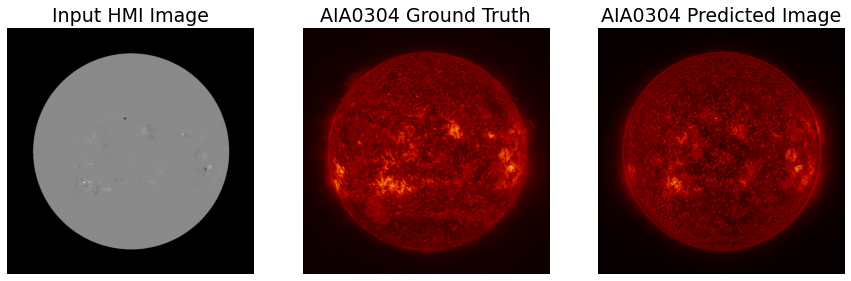

Epoch:  11
....................................................................................................
....................................................................................................
....................................................................................................
.........................................

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

<Figure size 1080x1080 with 0 Axes>

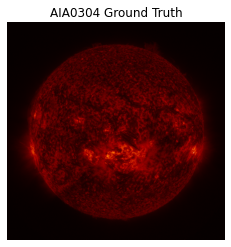

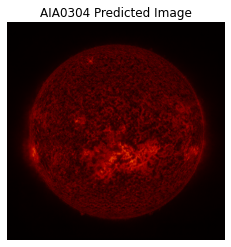

In [ ]:
# # Run the trained model on a few examples from the test dataset
# for inp, tar in test_dataset.take(1):
#   generate_test_images(generator, inp, tar)

In [ ]:
from tensorflow import keras
trained_model = keras.models.load_model('/content/drive/MyDrive/NEW_JSOC_CODE_DATA/ImagesAndModels/2012_13_14_train_test/model_149.h5')
trained_model.compile()

<Figure size 1080x1080 with 0 Axes>

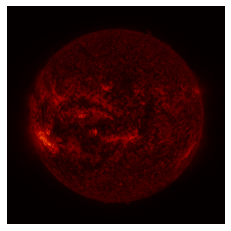

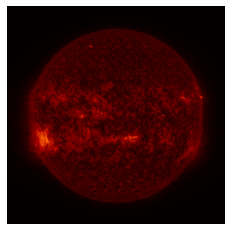

In [ ]:
# # Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(1):
  generate_test_images(trained_model, inp, tar)

In [ ]:
# Read images from file.
image1 = tf.io.read_file('/content/drive/MyDrive/NEW_JSOC_CODE_DATA/ImagesAndModels/2012_13_14_train_test/testingReal_aia0304.png')
image2 = tf.io.read_file('/content/drive/MyDrive/NEW_JSOC_CODE_DATA/ImagesAndModels/2012_13_14_train_test/testingPredicted_aia0304.png')
image1 = tf.image.decode_png(image1)
image2 = tf.image.decode_png(image2)
# Compute SSIM over tf.uint8 Tensors.
ssim1 = tf.image.ssim(image1, image2, max_val=255, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(ssim1.numpy())
# # Compute SSIM over tf.float32 Tensors.
# image1 = tf.image.convert_image_dtype(image1, tf.float32)
# image2 = tf.image.convert_image_dtype(image2, tf.float32)
# ssim2 = tf.image.ssim(image1, image2, max_val=1.0, filter_size=11,
#                           filter_sigma=1.5, k1=0.01, k2=0.03)
# print(ssim2)
# # ssim1 and ssim2 both have type tf.float32 and are almost equal.

0.9100742


In [ ]:
import numpy as np
def mse(imageA, imageB):

	err = np.sum((imageA.numpy().astype("float") - imageB.numpy().astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	return err

In [ ]:
mse(image1, image2)

342.89365311672947